Car order: ['WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC', 'WEAD', 'PROFACC']


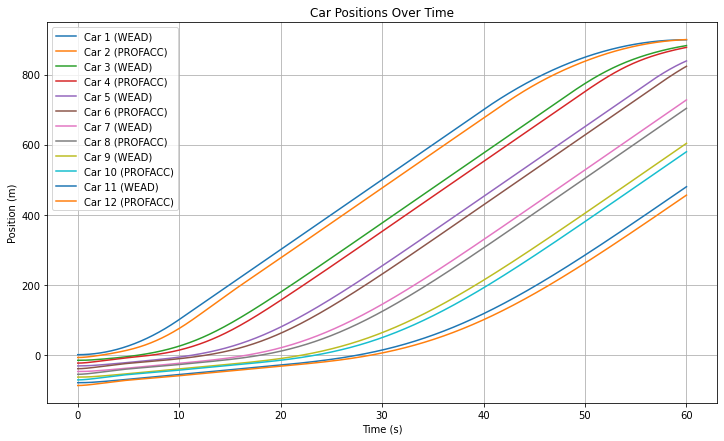

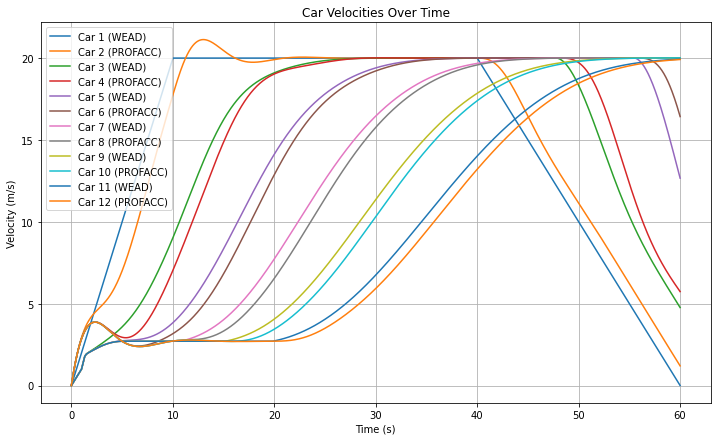

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
#  WEAD CONTROLLER
# ============================================================
def wead_controller(sn, vn):
    STOPPED_SPEED_TH = 1.0
    STOPPED_MIN_GAP = 5.0
    STOPPED_ACCEL = 1.0

    MAX_ACCEL = 2.5
    MAX_BRAKE = -2.5

    CRUISE_SPEED_LIMIT = 36.0

    if vn <= STOPPED_SPEED_TH:
        if sn > STOPPED_MIN_GAP:
            return STOPPED_ACCEL
        else:
            return 0.0

    time_gap = sn / vn if vn > 0 else float('inf')

    if time_gap <= 3:
        return MAX_BRAKE
    elif time_gap < 4:
        return (2.5 * time_gap) - 10
    elif time_gap <= 5:
        return 0.0
    elif time_gap < 6:
        return (2.5 * time_gap) - 12.5
    elif time_gap >= 6:
        return MAX_ACCEL if vn <= CRUISE_SPEED_LIMIT else 0.0

    return 0.0


# ============================================================
#  PROFACC CONTROLLER 
# ============================================================
def profacc_controller(sn, vn, alpha=0.5, tau=1.2):
    return alpha * (sn - tau * vn)


# ============================================================
# Leader velocity profile
# ============================================================
def leader_velocity(t):
    if t < 10:
        return 2.0 * t              # accelerate to 20 m/s
    elif t < 40:
        return 20.0                 # cruise
    else:
        return max(0, 20 - 1*(t-40))  # brake


# ============================================================
#  CAR ORDERING FUNCTION
# ============================================================
def assign_controllers(num_wead, ordering):
    total = 12
    num_prof = total - num_wead

    if ordering == "front":
        # WEAD at the front: [wead wead wead ... prof prof prof]
        return ["WEAD"] * num_wead + ["PROFACC"] * num_prof

    elif ordering == "back":
        # WEAD at the back: [prof prof prof ... wead wead wead]
        return ["PROFACC"] * num_prof + ["WEAD"] * num_wead

    elif ordering == "interspersed":
        # Every (total/num_wead)-th car is WEAD
        controller_list = ["PROFACC"] * total
        spacing = total / num_wead
        for i in range(num_wead):
            idx = int(i * spacing)
            controller_list[idx] = "WEAD"
        return controller_list

    else:
        raise ValueError("ordering must be 'front', 'back', or 'interspersed'")


# ============================================================
#  MAIN PLATOON SIMULATION
# ============================================================
def simulate_platoon(num_wead_cars, ordering):

    # Assign controllers
    controllers = assign_controllers(num_wead_cars, ordering)
    print("Car order:", controllers)

    dt = 0.05
    T = 60
    N = int(T/dt)

    t = np.linspace(0, T, N)

    # State arrays
    x = np.zeros((12, N))      # positions
    v = np.zeros((12, N))      # velocities
    a = np.zeros((12, N))      # accelerations
    gap = np.zeros((12, N))    # spacing

    # Initial positions (cars spaced 8 m apart)
    for i in range(12):
        x[i, 0] = -8 * i

    # Simulate
    for k in range(1, N):

        # === Leader motion ===
        v[0, k] = leader_velocity(t[k])
        x[0, k] = x[0, k-1] + v[0, k] * dt

        # === Followers ===
        for car in range(1, 12):

            sn = x[car-1, k-1] - x[car, k-1]   # gap
            vn = v[car, k-1]                   # own velocity
            gap[car, k] = sn

            # Choose controller
            if controllers[car] == "WEAD":
                acc = wead_controller(sn, vn)
            else:
                acc = profacc_controller(sn, vn)

            a[car, k] = acc
            v[car, k] = max(0, v[car, k-1] + acc * dt)
            x[car, k] = x[car, k-1] + v[car, k] * dt

    return t, x, v, controllers


# ============================================================
#  RUN + PLOT
# ============================================================
if __name__ == "__main__":
    num_wead_cars = 6            # you can change this
    ordering = "interspersed"    # front / back / interspersed

    t, x, v, controllers = simulate_platoon(num_wead_cars, ordering)

    # ---- Plot Positions ----
    plt.figure(figsize=(12,7))
    for car in range(12):
        plt.plot(t, x[car], label=f"Car {car+1} ({controllers[car]})")
    plt.title("Car Positions Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.grid()
    plt.legend()
    plt.show()

    # ---- Plot Velocities ----
    plt.figure(figsize=(12,7))
    for car in range(12):
        plt.plot(t, v[car], label=f"Car {car+1} ({controllers[car]})")
    plt.title("Car Velocities Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.grid()
    plt.legend()
    plt.show()
